# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
def MSG(txt):
    print('\n',datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), str(txt))
from ddpg_agent import Agent

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='data/Reacher_Linux/Reacher.x86_64')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [2]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [3]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.19899999555200337


### 3. Modified DDPG

[DDPG](https://arxiv.org/abs/1509.02971) is an actor-critic, model-free algorithm based on the deterministic policy gradient that can operate over continuous action spaces. 
![DDPG](src/img/DDPG.png)
Our algorithm is a distributed version of DDPG.

Details of algorithm:

1. 2-hidden layer (relu+bn) + tanh outlayer Actor Netwok
2. 2-hidden layer (relu+bn) + Linear outlayer  Critic Netwok
3. 1 shared Critic/Actor Network + 20 OuNoise process for each agent

Some hyper-parameters:

Hyper-Parameter | Value | Description
----------|-----------|--------------
BUFFER_SIZE | 2e6  | replay buffer size
BATCH_SIZE | 512        | minibatch size
GAMMA | 0.99           | discount factor
TAU | 1e-3              | for soft update of target parameters
LR_ACTOR | 5e-4         | learning rate of the actor
LR_CRITIC | 5e-4        | learning rate of the critic
WEIGHT_DECAY | 0        | L2 weight decay
UPDATE_EVERY | 25       | how often to update the network
LEARN_TIMES | 10        | how many times to learn each avtive step



 2018-11-07 17:32:15: start!
Episode 10	Current Episode Average Score: 0.99	Average Score on 100 Episode: 0.84
Episode 20	Current Episode Average Score: 2.11	Average Score on 100 Episode: 1.26
Episode 30	Current Episode Average Score: 15.59	Average Score on 100 Episode: 3.64
Episode 40	Current Episode Average Score: 30.01	Average Score on 100 Episode: 9.50
Episode 50	Current Episode Average Score: 38.36	Average Score on 100 Episode: 14.86
Episode 60	Current Episode Average Score: 37.60	Average Score on 100 Episode: 18.63
Episode 70	Current Episode Average Score: 38.32	Average Score on 100 Episode: 21.44
Episode 80	Current Episode Average Score: 38.64	Average Score on 100 Episode: 23.60
Episode 90	Current Episode Average Score: 38.14	Average Score on 100 Episode: 25.23
Episode 100	Current Episode Average Score: 36.48	Average Score on 100 Episode: 26.44
Episode 110	Current Episode Average Score: 35.82	Average Score on 100 Episode: 29.94
Episode 111	Current Episode Average Score: 34.75	A

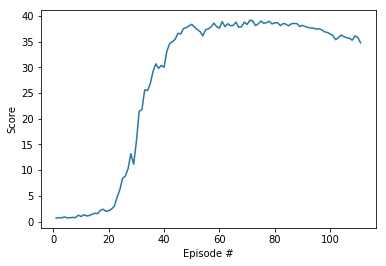

In [4]:
n_agent = 20
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2, n_agent=n_agent)
def ddpg(n_agent, n_episodes=300, max_t=1000, print_every=100):
    MSG('start!')
    scores_deque = deque(maxlen=print_every)
    scores = []
    best_score = 0.
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        agent_scores = [0]*n_agent
        for t in range(max_t):
            action = [agent.act(state[agent_x], agent_x) for agent_x in range(n_agent)]
            # get needed information from environment
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            for agent_x in range(n_agent):
                agent_scores[agent_x] += reward[agent_x]
                agent.step(state[agent_x], action[agent_x], reward[agent_x], 
                           next_state[agent_x], done[agent_x], agent_x)
            state = next_state
            if any(done):
                break
        score = np.mean(agent_scores)
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tCurrent Episode Average Score: {:.2f}\tAverage Score on 100 Episode: {:.2f}'.format(i_episode, score, np.mean(scores_deque)), end="")
        if score > best_score:
            torch.save(agent.actor_local.state_dict(), 'model/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'model/checkpoint_critic.pth')
            best_score = score
        if i_episode % (print_every/10) == 0:
            print('\rEpisode {}\tCurrent Episode Average Score: {:.2f}\tAverage Score on 100 Episode: {:.2f}'.format(i_episode, score, np.mean(scores_deque)))
        if score > 30 and np.mean(scores_deque) > 30:
            break
    MSG('end!') 
    return scores
scores = ddpg(n_agent)

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Have a look at well-trained agent

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
from datetime import datetime
from ddpg_agent import Agent
# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='data/Reacher_Linux/Reacher.x86_64')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents
num_agents = len(env_info.agents)
# size of each action
action_size = brain.vector_action_space_size
# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
n_agent = 20
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2, n_agent=n_agent)

agent.actor_local.load_state_dict(torch.load('model/checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('model/checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations
for t in range(200):
    action = [agent.act(state[agent_x], agent_x) for agent_x in range(n_agent)]
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations
    reward = env_info.rewards
    done = env_info.local_done
    state = next_state
    if all(done):
        break

env.close()

### Next Step

To improve the agent's performance:

1. During my experiments, I found the sample distribution does affect the performance a lot. Thus, I plan to build a heuristic method to maintain buffer replay and do sampling each training step. E.g. weighted sampling.
2. Try different noise generator.